<a href="https://colab.research.google.com/github/siddharthapramanik771/CreditCardFraudDetectionML/blob/main/Credit_card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary packages 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# Getting Relevant Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = 'drive/MyDrive/Data_for_ML/'
data_path = base_path + 'CreditCardTransactions.csv'
data = pd.read_csv(data_path)


In [ ]:
data.columns

Index(['Unnamed: 0', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'year', 'hour', 'month', 'dayofweek', 'day', 'age_group',
       'latitude_difference', 'longitude_difference', 'dist'],
      dtype='object')

In [ ]:
data.dtypes

Unnamed: 0                int64
cc_num                    int64
merchant                 object
category                 object
amt                     float64
first                    object
last                     object
gender                   object
street                   object
city                     object
state                    object
zip                       int64
lat                     float64
long                    float64
city_pop                  int64
job                      object
trans_num                object
unix_time                 int64
merch_lat               float64
merch_long              float64
is_fraud                  int64
year                      int64
hour                      int64
month                     int64
dayofweek                 int64
day                       int64
age_group                object
latitude_difference     float64
longitude_difference    float64
dist                    float64
dtype: object

# Data Analysis


In [ ]:
data['is_fraud'].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [ ]:
data.isnull().any().sum()

0

no mising data

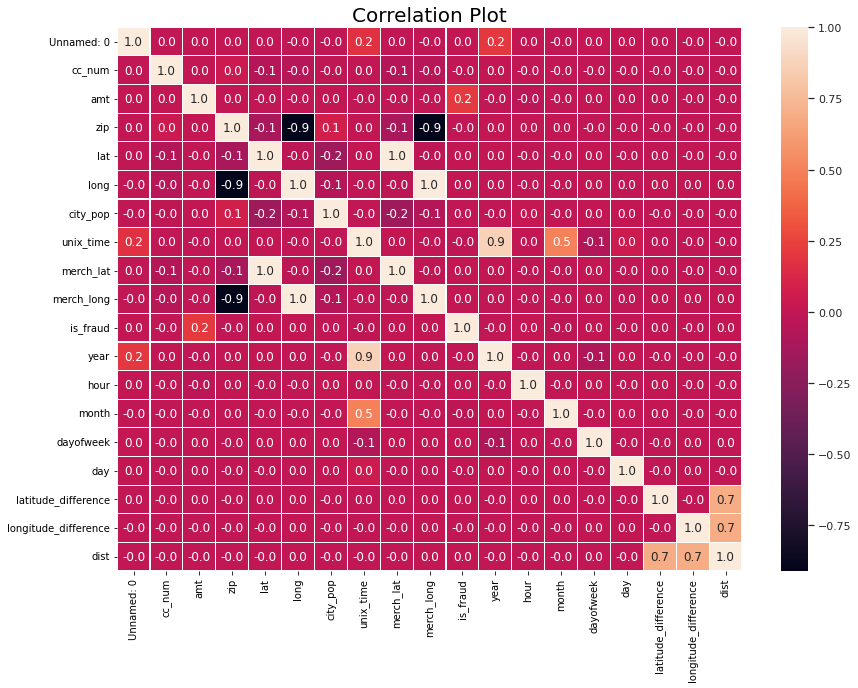

In [ ]:
plt.figure(figsize = (14,10))
plt.title('Correlation Plot', size = 20)
corr = data.corr()
sns.set(rc={'figure.figsize':(13.7,8.27)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,fmt='.1f',annot=True)
plt.show()

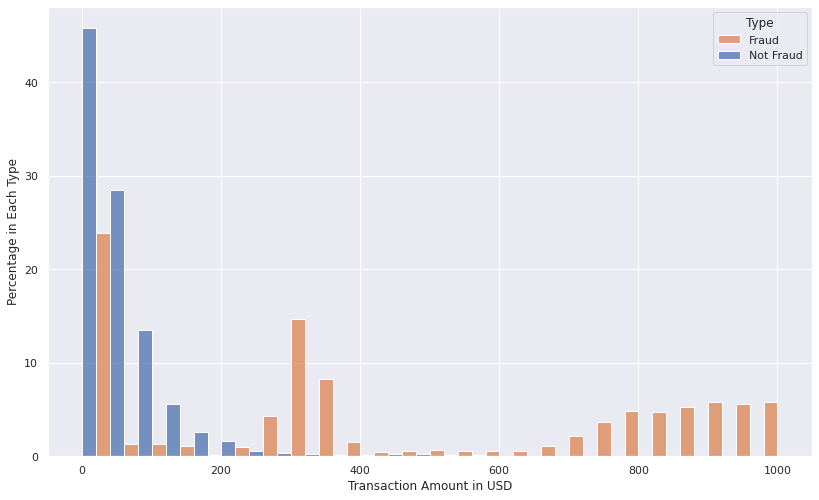

In [ ]:
df = data
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

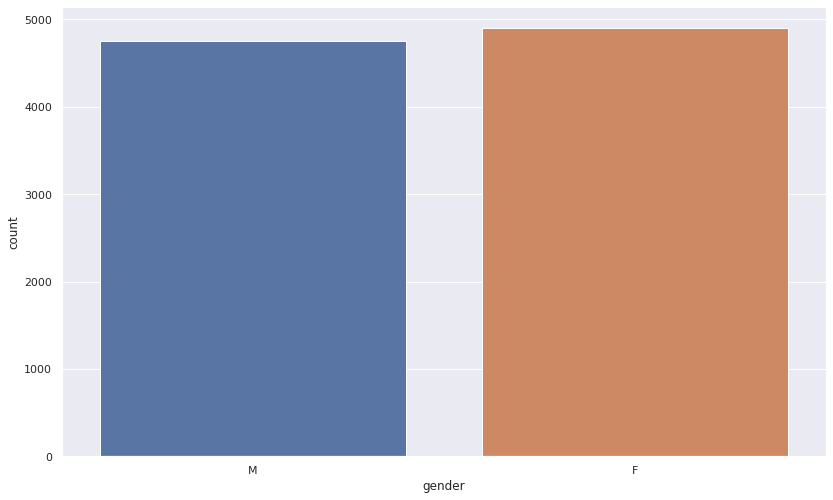

In [ ]:
sns.countplot(x="gender",data=df[df["is_fraud"]==1])

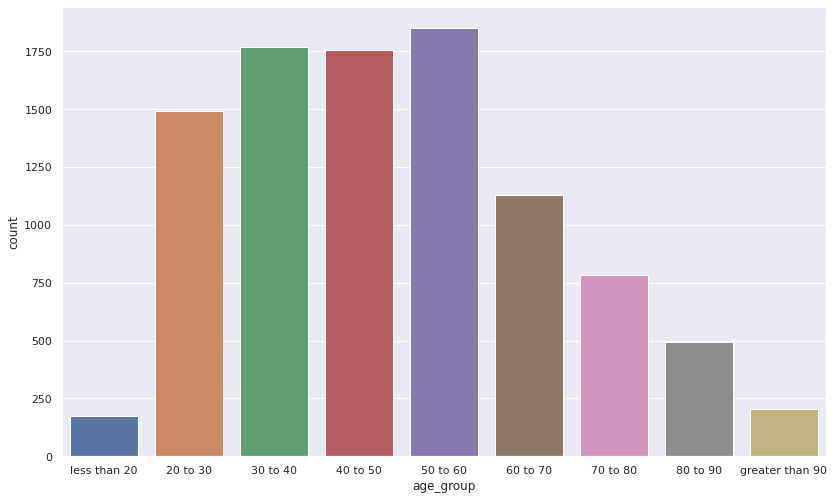

In [ ]:
order = ["less than 20","20 to 30","30 to 40","40 to 50","50 to 60","60 to 70","70 to 80","80 to 90","greater than 90"]
sns.countplot(x="age_group",data=df[df["is_fraud"]==1], order = order)

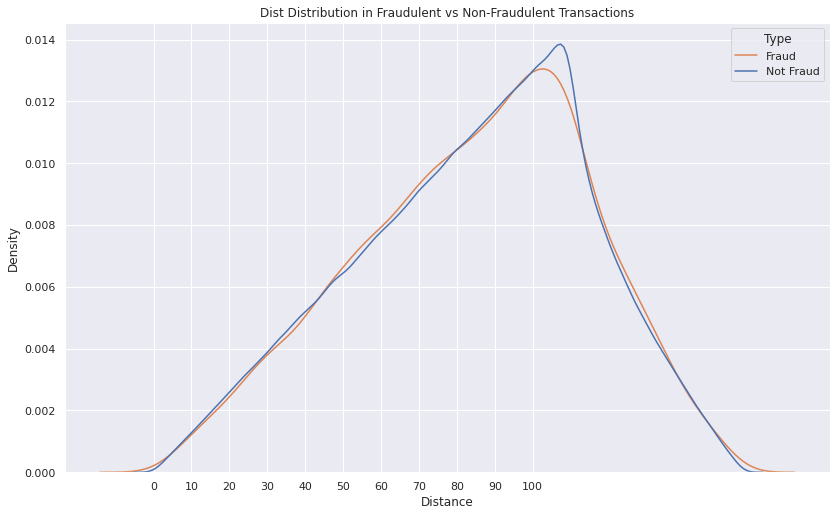

In [ ]:
#Relation between distance vs fraud
import datetime as dt
import numpy as np
ax=sns.kdeplot(x='dist',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,10))
plt.title('Dist Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

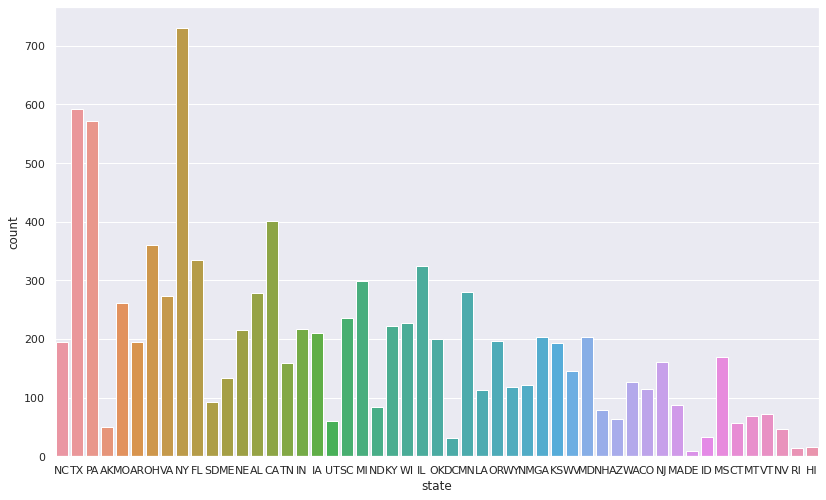

In [ ]:
sns.countplot(x="state",data=df[df["is_fraud"]==1])

# Data Pre-processing

In [ ]:
data.shape

(1852394, 30)

In [ ]:
data = data.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference"],1)
drop_cols = ["cc_num","merchant","first","last","street","trans_num","Unnamed: 0","city_pop","job","unix_time","trans_num","city","zip","year"]
data = data.drop(columns = drop_cols,axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
data.columns

Index(['category', 'amt', 'gender', 'state', 'is_fraud', 'hour', 'month',
       'dayofweek', 'day', 'age_group', 'dist'],
      dtype='object')

In [ ]:
data['is_fraud'].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [ ]:
non_fraud = data[data['is_fraud']==0]
fraud = data[data['is_fraud']==1]

In [ ]:
non_fraud = non_fraud.sample(fraud.shape[0])
non_fraud.shape

(9651, 11)

In [ ]:
data = fraud.append(non_fraud, ignore_index=True)

In [ ]:
data['is_fraud'].value_counts()

1    9651
0    9651
Name: is_fraud, dtype: int64

In [ ]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
def data_processing(data,encoding=True):
  if encoding:
    print('One Hot Encoding is applied')
    data = pd.concat([data,pd.get_dummies(data["gender"]),pd.get_dummies(data["age_group"]),pd.get_dummies(data["state"]),pd.get_dummies(data["category"])],axis=1)
    data = data.drop(["gender","age_group","state","category"],1)
  y = data["is_fraud"]
  x = data.drop(["is_fraud"], axis = 1)   
  # Standardization
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)
  # If the training data imbalanced we’ll address this using Synthetic Minority Oversampling Technique (SMOTE). 
  # It is an oversampling technique that creates artificial minority class samples. 
  # In our case, it creates synthetic fraud instances and so corrects the imbalance in our dataset.
  # y_train.value_counts()
  if y_train.value_counts()[0] != y_train.value_counts()[1]:
    print('SMOTE is applied')
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
  return X_train,y_train,X_test,y_test,data  


In [ ]:
# y_test.value_counts()

In [ ]:
X_train,y_train,X_test,y_test,processed_data = data_processing(data)
y_train.value_counts()

One Hot Encoding is applied
SMOTE is applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


1    7731
0    7731
Name: is_fraud, dtype: int64

In [ ]:
processed_data.columns

Index(['amt', 'is_fraud', 'hour', 'month', 'dayofweek', 'day', 'dist', 'F',
       'M', '20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70',
       '70 to 80', '80 to 90', 'greater than 90', 'less than 20', 'AK', 'AL',
       'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY', 'entertainment', 'food_dining', 'gas_transport', 'grocery_net',
       'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
       'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'],
      dtype='object')

In [ ]:
data.columns

Index(['category', 'amt', 'gender', 'state', 'is_fraud', 'hour', 'month',
       'dayofweek', 'day', 'age_group', 'dist'],
      dtype='object')

# Model Building

## using scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score,mean_absolute_error
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

model_impl = RandomForestClassifier()
# X_train = X_train.reshape(X_train.shape[0],1)
# X_test = X_test.reshape(X_test.shape[0],1)
model_impl.fit(X_train,y_train)
pred_train=model_impl.predict(X_train)
pred_test=model_impl.predict(X_test)

accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)
confusionMatrix = confusion_matrix(y_test,pred_test)
classificationReport = classification_report(y_test,pred_test)
mae = mean_absolute_error(y_train,pred_train)
# print("Model Implemented: ", 'Decision_tree')
print("Accuracy on Training Set: ", accuracy_train)
print('Accuracy on Validation Set: ', accuracy_test)
print('Mean absolute error: ',mae)
print('Confusion Matrix\n', confusionMatrix)
print('Classification Report\n', classificationReport)

(15462, 82) (15462,) (3861, 82) (3861,)
Accuracy on Training Set:  1.0
Accuracy on Validation Set:  0.9735819735819736
Mean absolute error:  0.0
Confusion Matrix
 [[1904   37]
 [  65 1855]]
Classification Report
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1941
           1       0.98      0.97      0.97      1920

    accuracy                           0.97      3861
   macro avg       0.97      0.97      0.97      3861
weighted avg       0.97      0.97      0.97      3861



## using Tensorflow 

In [ ]:
X_train.shape

(15462, 82)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
epochs = 50
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())

model.add(Conv1D(32, 2, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 81, 64)            192       
                                                                 
 batch_normalization_3 (Batc  (None, 81, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, 80, 32)            4128      
                                                                 
 dropout_6 (Dropout)         (None, 80, 32)            0         
                                                                 
 dense_9 (Dense)             (None, 80, 64)            2112      
                                                                 
 flatten_3 (Flatten)         (None, 5120)              0         
                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1,callbacks = [callback])

Epoch 1/50
484/484 [==============================] - 4s 7ms/step - loss: 0.3475 - accuracy: 0.8355 - val_loss: 0.2718 - val_accuracy: 0.8785
Epoch 2/50
484/484 [==============================] - 3s 6ms/step - loss: 0.2512 - accuracy: 0.8831 - val_loss: 0.2458 - val_accuracy: 0.8889
Epoch 3/50
484/484 [==============================] - 3s 6ms/step - loss: 0.2271 - accuracy: 0.8975 - val_loss: 0.2301 - val_accuracy: 0.8985
Epoch 4/50
484/484 [==============================] - 3s 6ms/step - loss: 0.2094 - accuracy: 0.9111 - val_loss: 0.2082 - val_accuracy: 0.9093
Epoch 5/50
484/484 [==============================] - 3s 6ms/step - loss: 0.1999 - accuracy: 0.9137 - val_loss: 0.2014 - val_accuracy: 0.9132
Epoch 6/50
484/484 [==============================] - 3s 6ms/step - loss: 0.1887 - accuracy: 0.9184 - val_loss: 0.2049 - val_accuracy: 0.9130
Epoch 7/50
484/484 [==============================] - 3s 6ms/step - loss: 0.1805 - accuracy: 0.9211 - val_loss: 0.1839 - val_accuracy: 0.9223
Epoch 

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

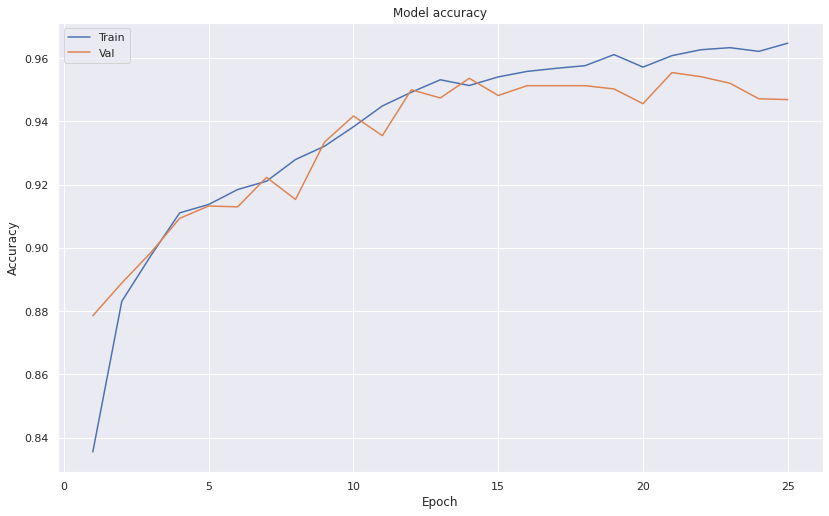

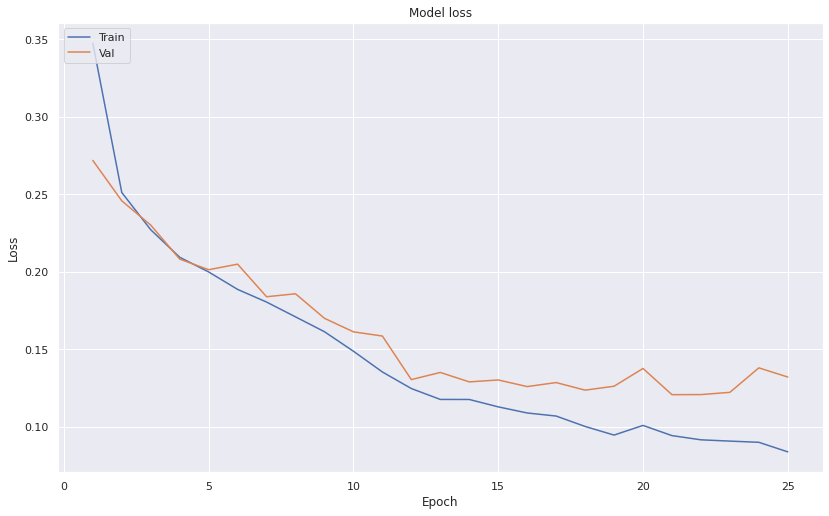

In [ ]:
plot_learningCurve(history,len(history.epoch))

In [ ]:
y_predict= model.predict(X_test)

121/121 [==============================] - 0s 2ms/step


In [ ]:
y_predict

array([[1.        ],
       [1.        ],
       [0.01541887],
       ...,
       [0.99954575],
       [0.0355013 ],
       [0.99961865]], dtype=float32)

In [ ]:
import numpy as np
y_predict = np.round(y_predict).astype(int)
y_predict

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
confusionMatrix = confusion_matrix(y_test,y_predict)
classificationReport = classification_report(y_test,y_predict)

In [ ]:
confusionMatrix

array([[1862,   79],
       [  93, 1827]])

In [ ]:
print(classificationReport)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1941
           1       0.96      0.95      0.96      1920

    accuracy                           0.96      3861
   macro avg       0.96      0.96      0.96      3861
weighted avg       0.96      0.96      0.96      3861

